# Online style transfer

In this task you will have to:
1. implement Gramm matrices calculation (mind normalization term)
2. implement image transformation network (with some stated modifications, no other modifications are needed.)
3. train 2 image transformation networks on 2 styles from images/styles
4. apply each of trained models to every content image from images/contents, visualize
5. answer some general questions on style transfer at the end of this notebook

Make sure stylizations are good before submitting and resized for comfortable viewing. 
You should submit only modified Jupyter notebook with outputs and visualizations without any extra files (images, models, etc.)

In [1]:
from collections import namedtuple

import torch
from torchvision import models
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import argparse
import os
import sys
import time
from datetime import datetime
import re
from IPython.display import display

import numpy as np

from pdb import set_trace as bp

In [2]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if img.mode!='RGB':
        img = img.convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8") # CHW->HWC
    img = Image.fromarray(img)
    img.save(filename)


def gram_matrix(y):
    '''Here you should return batch of Gramm matrices (see eq.3 from 
    https://arxiv.org/pdf/1603.08155.pdf), each divided by 
    (#channels) x (height) x (width) of feature map.'''
    # your code here
    batch_size, channels, height, weight = y.size()
    x = y.view(batch_size, channels, height*weight)
    gram = torch.bmm(x, x.transpose(2, 1))
    return gram.div_(channels * height * weight)


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(1,-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(1,-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

In [3]:
from torch import nn
import torch.nn.functional as F
'''Here you should realize Image Transform Net - fig.2 from https://arxiv.org/pdf/1603.08155.pdf.
Its structure should be from https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
with 2 modifications: 
1) batch normalizations should be substituted by instance normalizations with learnable parameters.
See https://arxiv.org/pdf/1607.08022.pdf
2) Transposed convolutions with stride 1/2 should be replaced by UpsampleConvLayer, which:
    a) upsamples image 2 times with nearest neighbour estimation - use torch.nn.Upsample
    b) performs reflection padding with pad=conv_kernel_size // 2
    c) applies conv
This method gives better results compared to ConvTranspose2d, see 
http://distill.pub/2016/deconv-checkerboard/'''

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()     
    # your code here
        self.pad1 = nn.ReflectionPad2d(9//2)
        self.conv1 = nn.Conv2d(3, 32, 9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.pad2 = nn.ReflectionPad2d(3//2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.pad3 = nn.ReflectionPad2d(3//2)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        self.res_block1 = ResidualBlock(128)
        self.res_block2 = ResidualBlock(128)
        self.res_block3 = ResidualBlock(128)
        self.res_block4 = ResidualBlock(128)
        self.res_block5 = ResidualBlock(128)
        self.conv4 = UpsampleConvLayer(128, 64, 3, 1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.conv5 = UpsampleConvLayer(64, 32, 3, 1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.pad6 = nn.ReflectionPad2d(9//2)
        self.conv6 = nn.Conv2d(32, 3, 9, stride=1)

    def forward(self, X):
    # your code here
        y = self.pad1(X)
        y = self.conv1(y)
        y = F.relu(self.in1(y))
        y = self.pad2(y)
        y = self.conv2(y)
        y = F.relu(self.in2(y))
        y = self.pad3(y)
        y = self.conv3(y)
        y = F.relu(self.in3(y))
        y = self.res_block1(y)
        y = self.res_block2(y)
        y = self.res_block3(y)
        y = self.res_block4(y)
        y = self.res_block5(y)
        y = self.conv4(y)
        y = F.relu(self.in4(y))
        y = self.conv5(y)
        y = F.relu(self.in5(y))
        y = self.pad6(y)
        y = self.conv6(y)
        return y


class ResidualBlock(nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        # your code here
        self.pad1 = nn.ReflectionPad2d(3//2)
        self.conv1 = nn.Conv2d(channels, channels, 3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.pad2 = nn.ReflectionPad2d(3//2)
        self.conv2 = nn.Conv2d(channels, channels, 3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        # your code here
        y = x
        y = self.pad1(y)
        y = self.conv1(y)
        y = F.relu(self.in1(y))
        y = self.pad2(y)
        y = self.conv2(y)
        y = self.in2(y)
        out = y + x
        out = F.relu(out)
        return out
        
        
class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer, which:
    a) upsamples image 2 times with nearest neighbour estimation - use torch.nn.Upsample
    b) performs reflection padding with pad=conv_kernel_size // 2
    c) applies conv
        This method gives better results compared to ConvTranspose2d, see 
        http://distill.pub/2016/deconv-checkerboard/
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        # your code here
        self.scale_factor = upsample
#         self.upsample = nn.Upsample(scale_factor=self.scale_factor, mode='nearest')
        self.reflection = nn.ReflectionPad2d(kernel_size // 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        # your code here
        y = x
        if self.scale_factor:
            y = F.interpolate(y, scale_factor=self.scale_factor, mode='nearest')
        y = self.reflection(y)
        y = self.conv(y)
        return y

In [4]:
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [5]:
def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)


def train(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(args.style_image, size=args.style_size)
    style = style_transform(style)
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    style_name = args.style_image
    i=style_name.rfind('/')
    if i>=0:
        style_name=style_name[i+1:]
    style_name=style_name[:style_name.rfind('.')]

    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(y) for y in features_style]

    cum_content_loss = 0.
    cum_style_loss = 0.
    img_count = 0
    batch_count = 0
    transformer.train()
    
    print('Training for %s...'%style_name)
    for epoch in range(1,100): 
        if img_count>args.max_train_count:
            break
            
        for (x, _) in train_loader:
            if img_count>args.max_train_count:
                break
            
            
            n_batch = len(x)
            img_count += n_batch
            batch_count += 1
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= args.style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            cum_content_loss += content_loss.item()
            cum_style_loss += style_loss.item()

            if batch_count % args.log_batches_interval == 0:
                print("%6s %6s %2s %s content: %.1f style: %.1f total: %.1f"%(
                                  img_count,batch_count,epoch, datetime.now().strftime('%H:%M:%S'),
                                  cum_content_loss / img_count,
                                  cum_style_loss / img_count,
                                  (cum_content_loss + cum_style_loss) / img_count))
    
            if (args.checkpoint_model_dir!=None) and (batch_count % args.checkpoint_batches_interval == 0):
                transformer.eval().cpu()
                ckpt_model_filename = "model_%s_%s.pth"%(style_name,img_count)
                ckpt_model_path = os.path.join(args.checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                transformer.to(device).train()

    # save model
    transformer.eval().cpu()
    save_model_filename = "model_%s_%s.pth"%(style_name,img_count)
    save_model_path = os.path.join(args.save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)

    print("\nFinished, model saved to %s\n"%save_model_path)


def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        state_dict = torch.load(args.model)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(device)
        output = style_model(content_image).cpu()
    save_image(args.output_image, output[0])

In [6]:
def main(args):

    main_arg_parser = argparse.ArgumentParser(description="parser for online-style-stransfer")
    
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--max-train-count", type=int, default=50000,
                                  help="number of training images, default is 50000")
    train_arg_parser.add_argument("--batch-size", type=int, default=4,
                                  help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images/style-images/mosaic.jpg",
                                  help="path to style-image")

    train_arg_parser.add_argument("--image-size", type=int, default=256,
                                  help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None,
                                  help="size of style-image, default is the original size of style image")

    train_arg_parser.add_argument("--save-model-dir", type=str, required=True,
                                  help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None,
                                  help="path to folder where checkpoints of trained models will be saved")

    train_arg_parser.add_argument("--cuda", type=int, required=True,
                                  help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42,
                                  help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5,
                                  help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10,
                                  help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3,
                                  help="learning rate, default is 1e-3")

    train_arg_parser.add_argument("--log-batches-interval", type=int, default=1000,
                                  help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-batches-interval", type=int, default=10000,
                                  help="number of batches after which a checkpoint of the trained model will be created")

    eval_arg_parser = subparsers.add_parser("eval", help="parser for evaluation/stylizing arguments")
    eval_arg_parser.add_argument("--content-image", type=str, required=True,
                                 help="path to content image you want to stylize")
    eval_arg_parser.add_argument("--content-scale", type=float, default=None,
                                 help="factor for scaling down the content image")
    eval_arg_parser.add_argument("--output-image", type=str, required=True,
                                 help="path for saving the output image")
    eval_arg_parser.add_argument("--model", type=str, required=True,
                                 help="saved model to be used for stylizing the image. If file ends in .pth - PyTorch path is used, if in .onnx - Caffe2 path")
    eval_arg_parser.add_argument("--cuda", type=int, required=True,
                                 help="set it to 1 for running on GPU, 0 for CPU")

    args = main_arg_parser.parse_args(args)
    
    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)

    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)

# Train generator netoworks

In [7]:
# Train 2 generators for 2 style images from "images/styles"
# Train on MS COCO 2017 validation dataset from http://cocodataset.org/#download
# Training on 30000 images (6 epochs over the dataset) is sufficient for these styles.
# Mind that MS COCO 2017 validation dataset images should be placed inside some other folder, e.g.:
# /MS_COCO_2017_validation_dataset/images/

# your code here, you should use:
# main([ 'train',
#        '--save-model-dir','saved_models/',
#        '--max-train-count','30000',
#        '--log-batches-interval','200',
#        '--checkpoint-batches-interval','2000',
#        '--batch-size','6',
#        '--checkpoint-model-dir','intermediate_models/',
#        '--style-image','<link to style image>',
#        '--dataset','<link to MS COCO 2017 validation dataset>',
#        '--cuda','1',
#     ])
main([ 'train',
       '--save-model-dir','saved_models/',
       '--max-train-count','30000',
       '--log-batches-interval','200',
       '--checkpoint-batches-interval','2000',
       '--batch-size','6',
       '--checkpoint-model-dir','intermediate_models/',
       '--style-image','images/styles/sea.png',
       '--dataset','MS_COCO_2017_validation_dataset/image/',
       '--image-size', '128',
       '--cuda','1',
    ])

Training for sea...
  1200    200  1 21:16:05 content: 202926.9 style: 1391373.1 total: 1594300.0
  2400    400  1 21:16:39 content: 229631.9 style: 865813.4 total: 1095445.3
  3600    600  1 21:17:13 content: 240807.3 style: 633921.5 total: 874728.7
  4800    800  1 21:17:47 content: 245314.5 style: 504639.8 total: 749954.3
  5996   1000  2 21:18:21 content: 246464.5 style: 423544.7 total: 670009.2
  7196   1200  2 21:18:55 content: 245798.9 style: 367899.2 total: 613698.2
  8396   1400  2 21:19:29 content: 244377.4 style: 327504.0 total: 571881.4
  9596   1600  2 21:20:03 content: 242464.1 style: 296701.5 total: 539165.7
 10792   1800  3 21:20:37 content: 240334.4 style: 272557.7 total: 512892.1
 11992   2000  3 21:21:11 content: 238020.5 style: 253003.7 total: 491024.2
 13192   2200  3 21:21:45 content: 235641.5 style: 236915.3 total: 472556.7
 14392   2400  3 21:22:19 content: 233340.0 style: 223355.3 total: 456695.4
 15588   2600  4 21:22:53 content: 231179.7 style: 211841.7 total

In [8]:
main([ 'train',
       '--save-model-dir','saved_models/',
       '--max-train-count','30000',
       '--log-batches-interval','200',
       '--checkpoint-batches-interval','2000',
       '--batch-size','6',
       '--checkpoint-model-dir','intermediate_models/',
       '--style-image','images/styles/puantilism.jpg',
       '--dataset','MS_COCO_2017_validation_dataset/image/',
       '--image-size', '128',
       '--cuda','1',
    ])

Training for puantilism...
  1200    200  1 21:30:18 content: 211124.2 style: 2455569.9 total: 2666694.1
  2400    400  1 21:30:52 content: 245495.9 style: 1383421.8 total: 1628917.7
  3600    600  1 21:31:26 content: 258879.7 style: 974241.3 total: 1233121.0
  4800    800  1 21:32:00 content: 264855.9 style: 759250.1 total: 1024106.0
  5996   1000  2 21:32:34 content: 267190.1 style: 627053.7 total: 894243.8
  7196   1200  2 21:33:08 content: 267310.9 style: 536119.8 total: 803430.7
  8396   1400  2 21:33:42 content: 266527.4 style: 469443.7 total: 735971.1
  9596   1600  2 21:34:16 content: 265112.5 style: 418353.1 total: 683465.5
 10792   1800  3 21:34:50 content: 263371.5 style: 378233.1 total: 641604.6
 11992   2000  3 21:35:24 content: 261363.4 style: 345664.3 total: 607027.7
 13192   2200  3 21:35:58 content: 259406.9 style: 318895.1 total: 578302.0
 14392   2400  3 21:36:33 content: 257424.4 style: 296479.1 total: 553903.5
 15588   2600  4 21:37:07 content: 255564.5 style: 2774

In [18]:
paths = ['images/contents/000000000285.jpg',
         'images/contents/000000001296.jpg',
         'images/contents/000000001584.jpg',
         'images/contents/000000009448.jpg',
         'images/contents/000000039670.jpg',
         'images/contents/000000079188.jpg'
]
style = 'puantilism'
for i,p in enumerate(paths):
    main(['eval',
      '--content-image', p,
      '--model', 'saved_models/model_puantilism_30006.pth',
      '--output-image', 'images/results/'+ style + str(i) + '.jpg',
      '--cuda', '1'
])

# Visualize stylizations

In [58]:
# Each visualized image should comfortably fit into the screen - 
# it should not be too large or too small.
# Use e.g. img.resize()
from matplotlib import pyplot as plt
import os, os.path
%matplotlib inline
path_c = 'images/contents/'
path_s = 'images/styles/'
path_r = 'images/results/'
size = 256

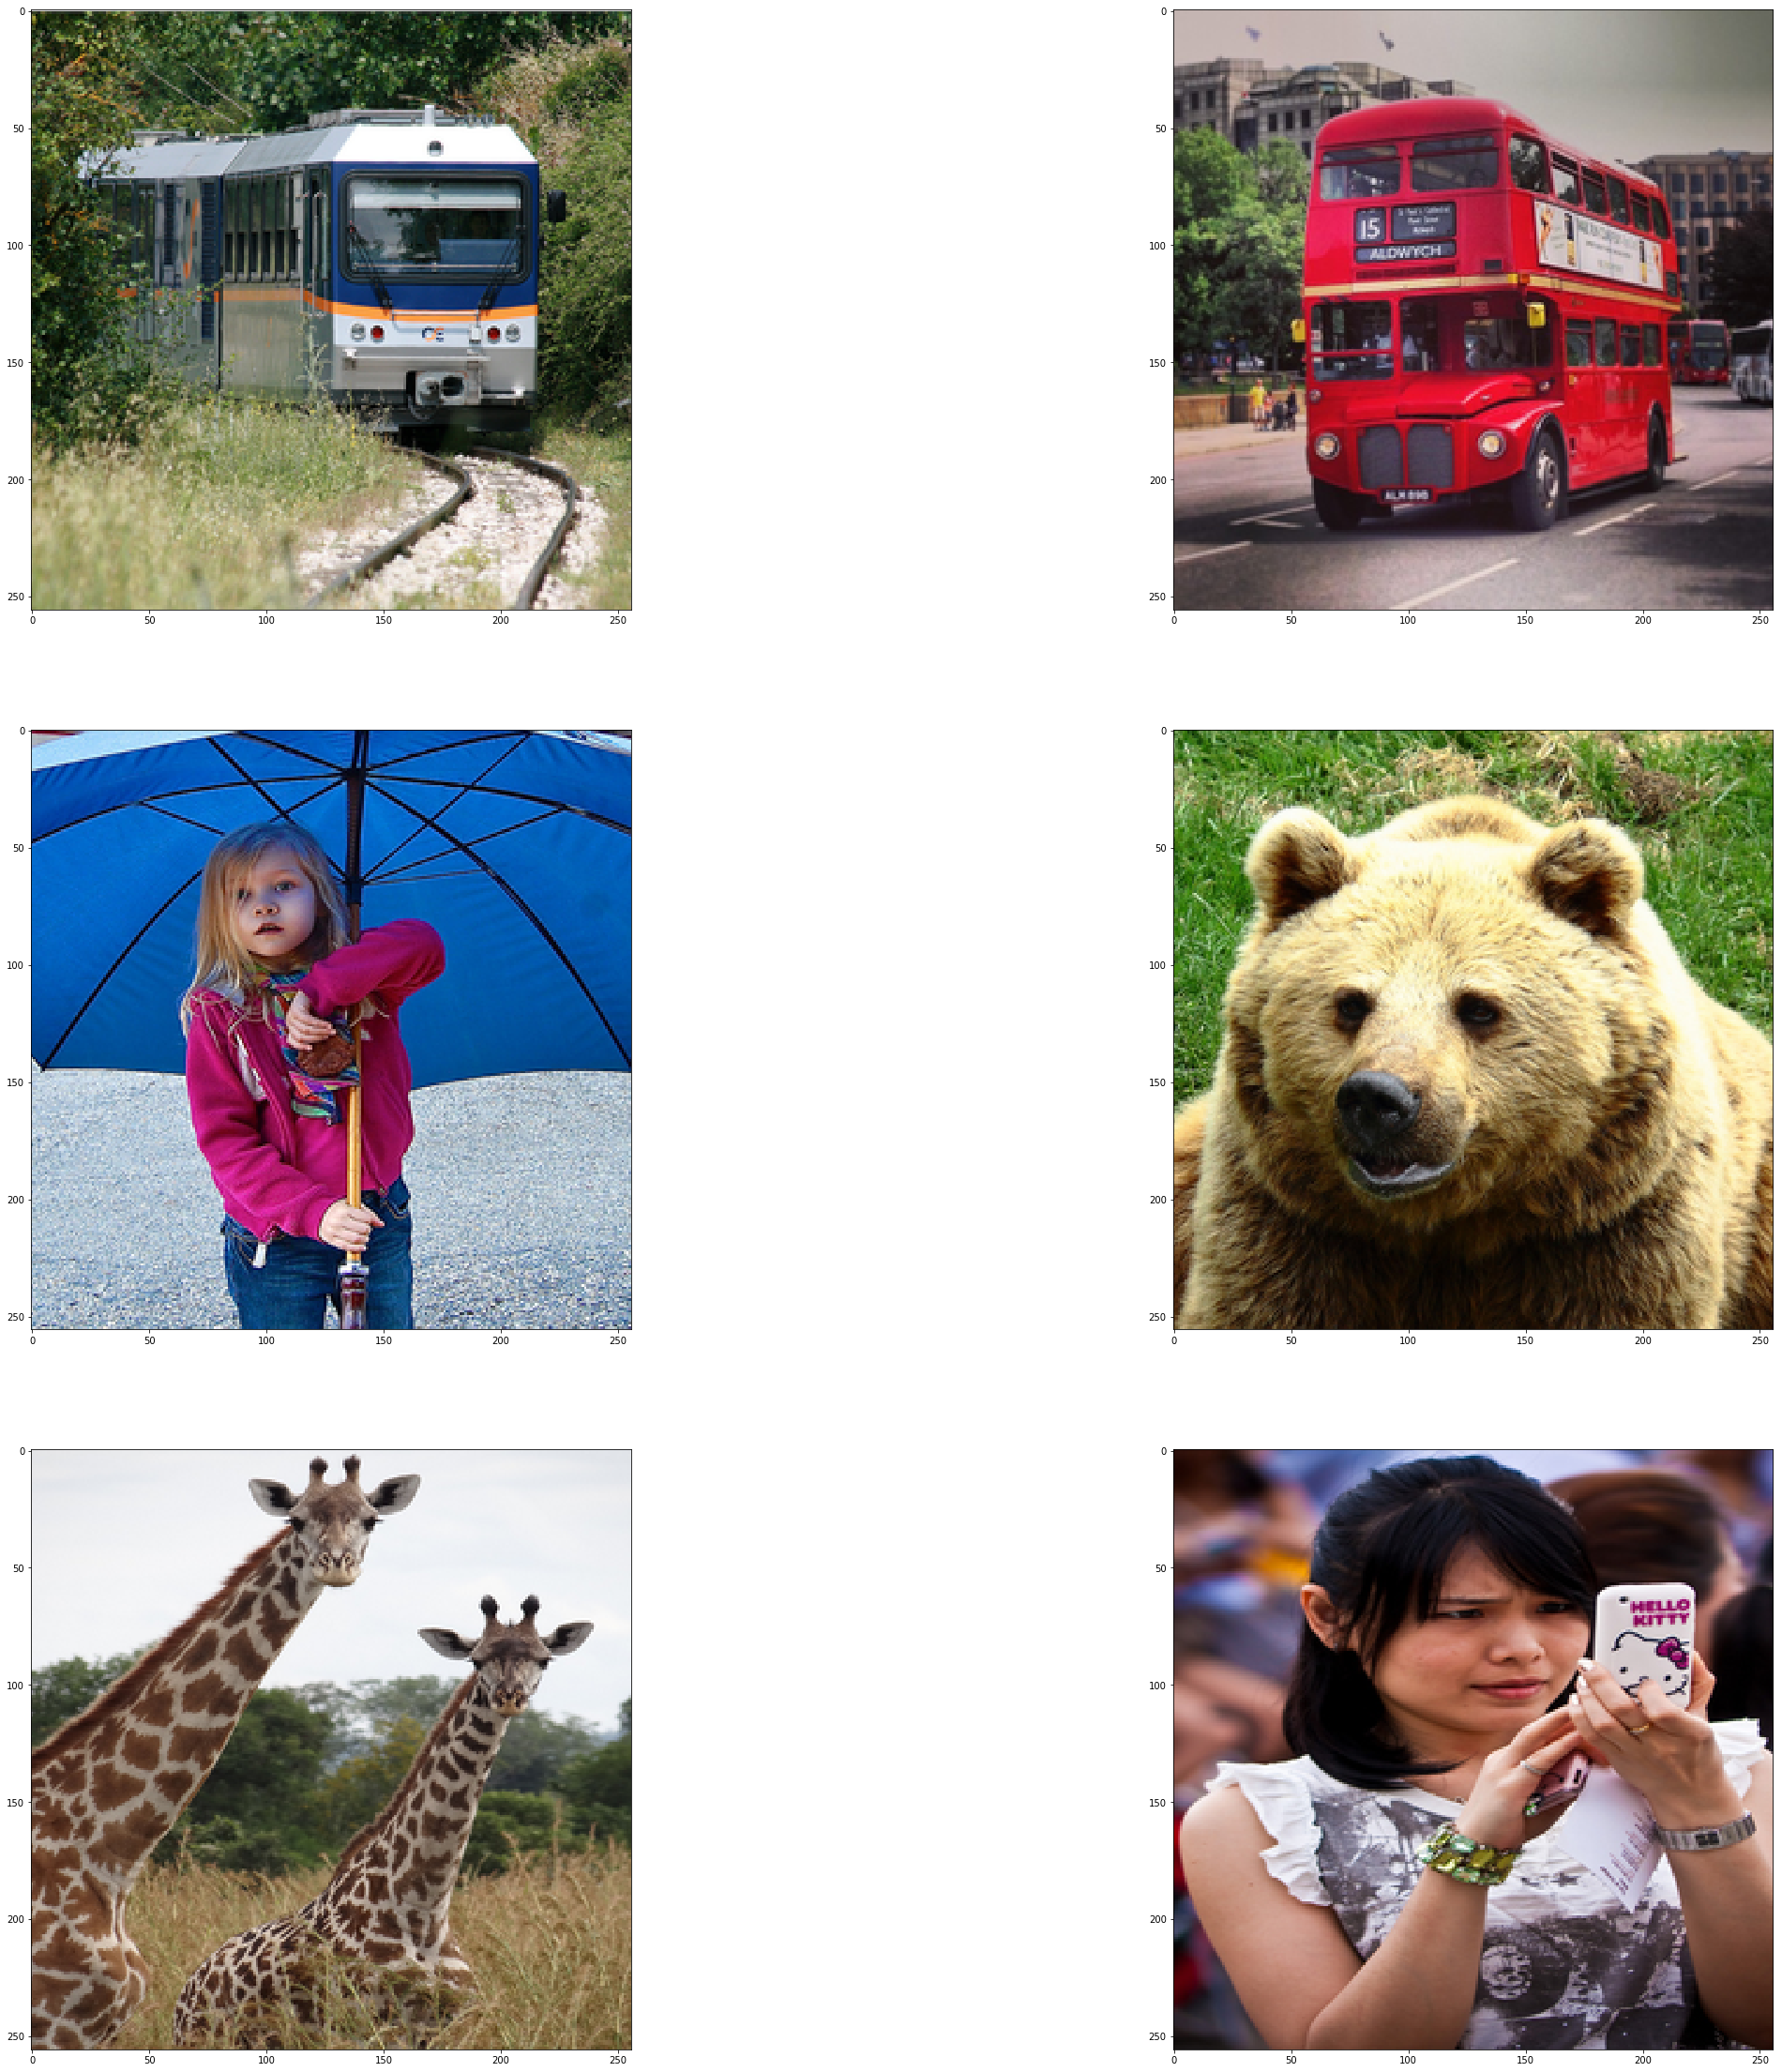

In [59]:
# visualize all images from images/contents
contents = []
for file in os.listdir(path_c):
    if file.endswith('.jpg'):
        contents.append(load_image(path_c + file, size))
fig = plt.figure(figsize=(40, 40))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(contents[i])
plt.show()

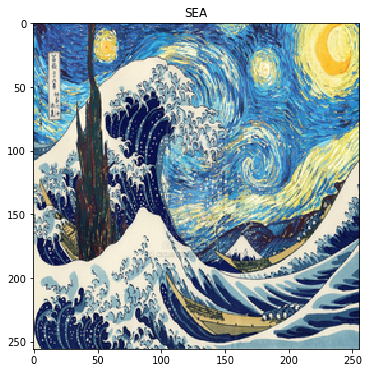

In [60]:
# visualize style1 from images/styles
styles=[]
for file in os.listdir(path_s):
    if file.endswith((".jpg", ".png")):
        styles.append(load_image(path_s + file, size))
fig = plt.figure(figsize=(6, 6))
plt.imshow(styles[0])
plt.title("SEA")
plt.show()

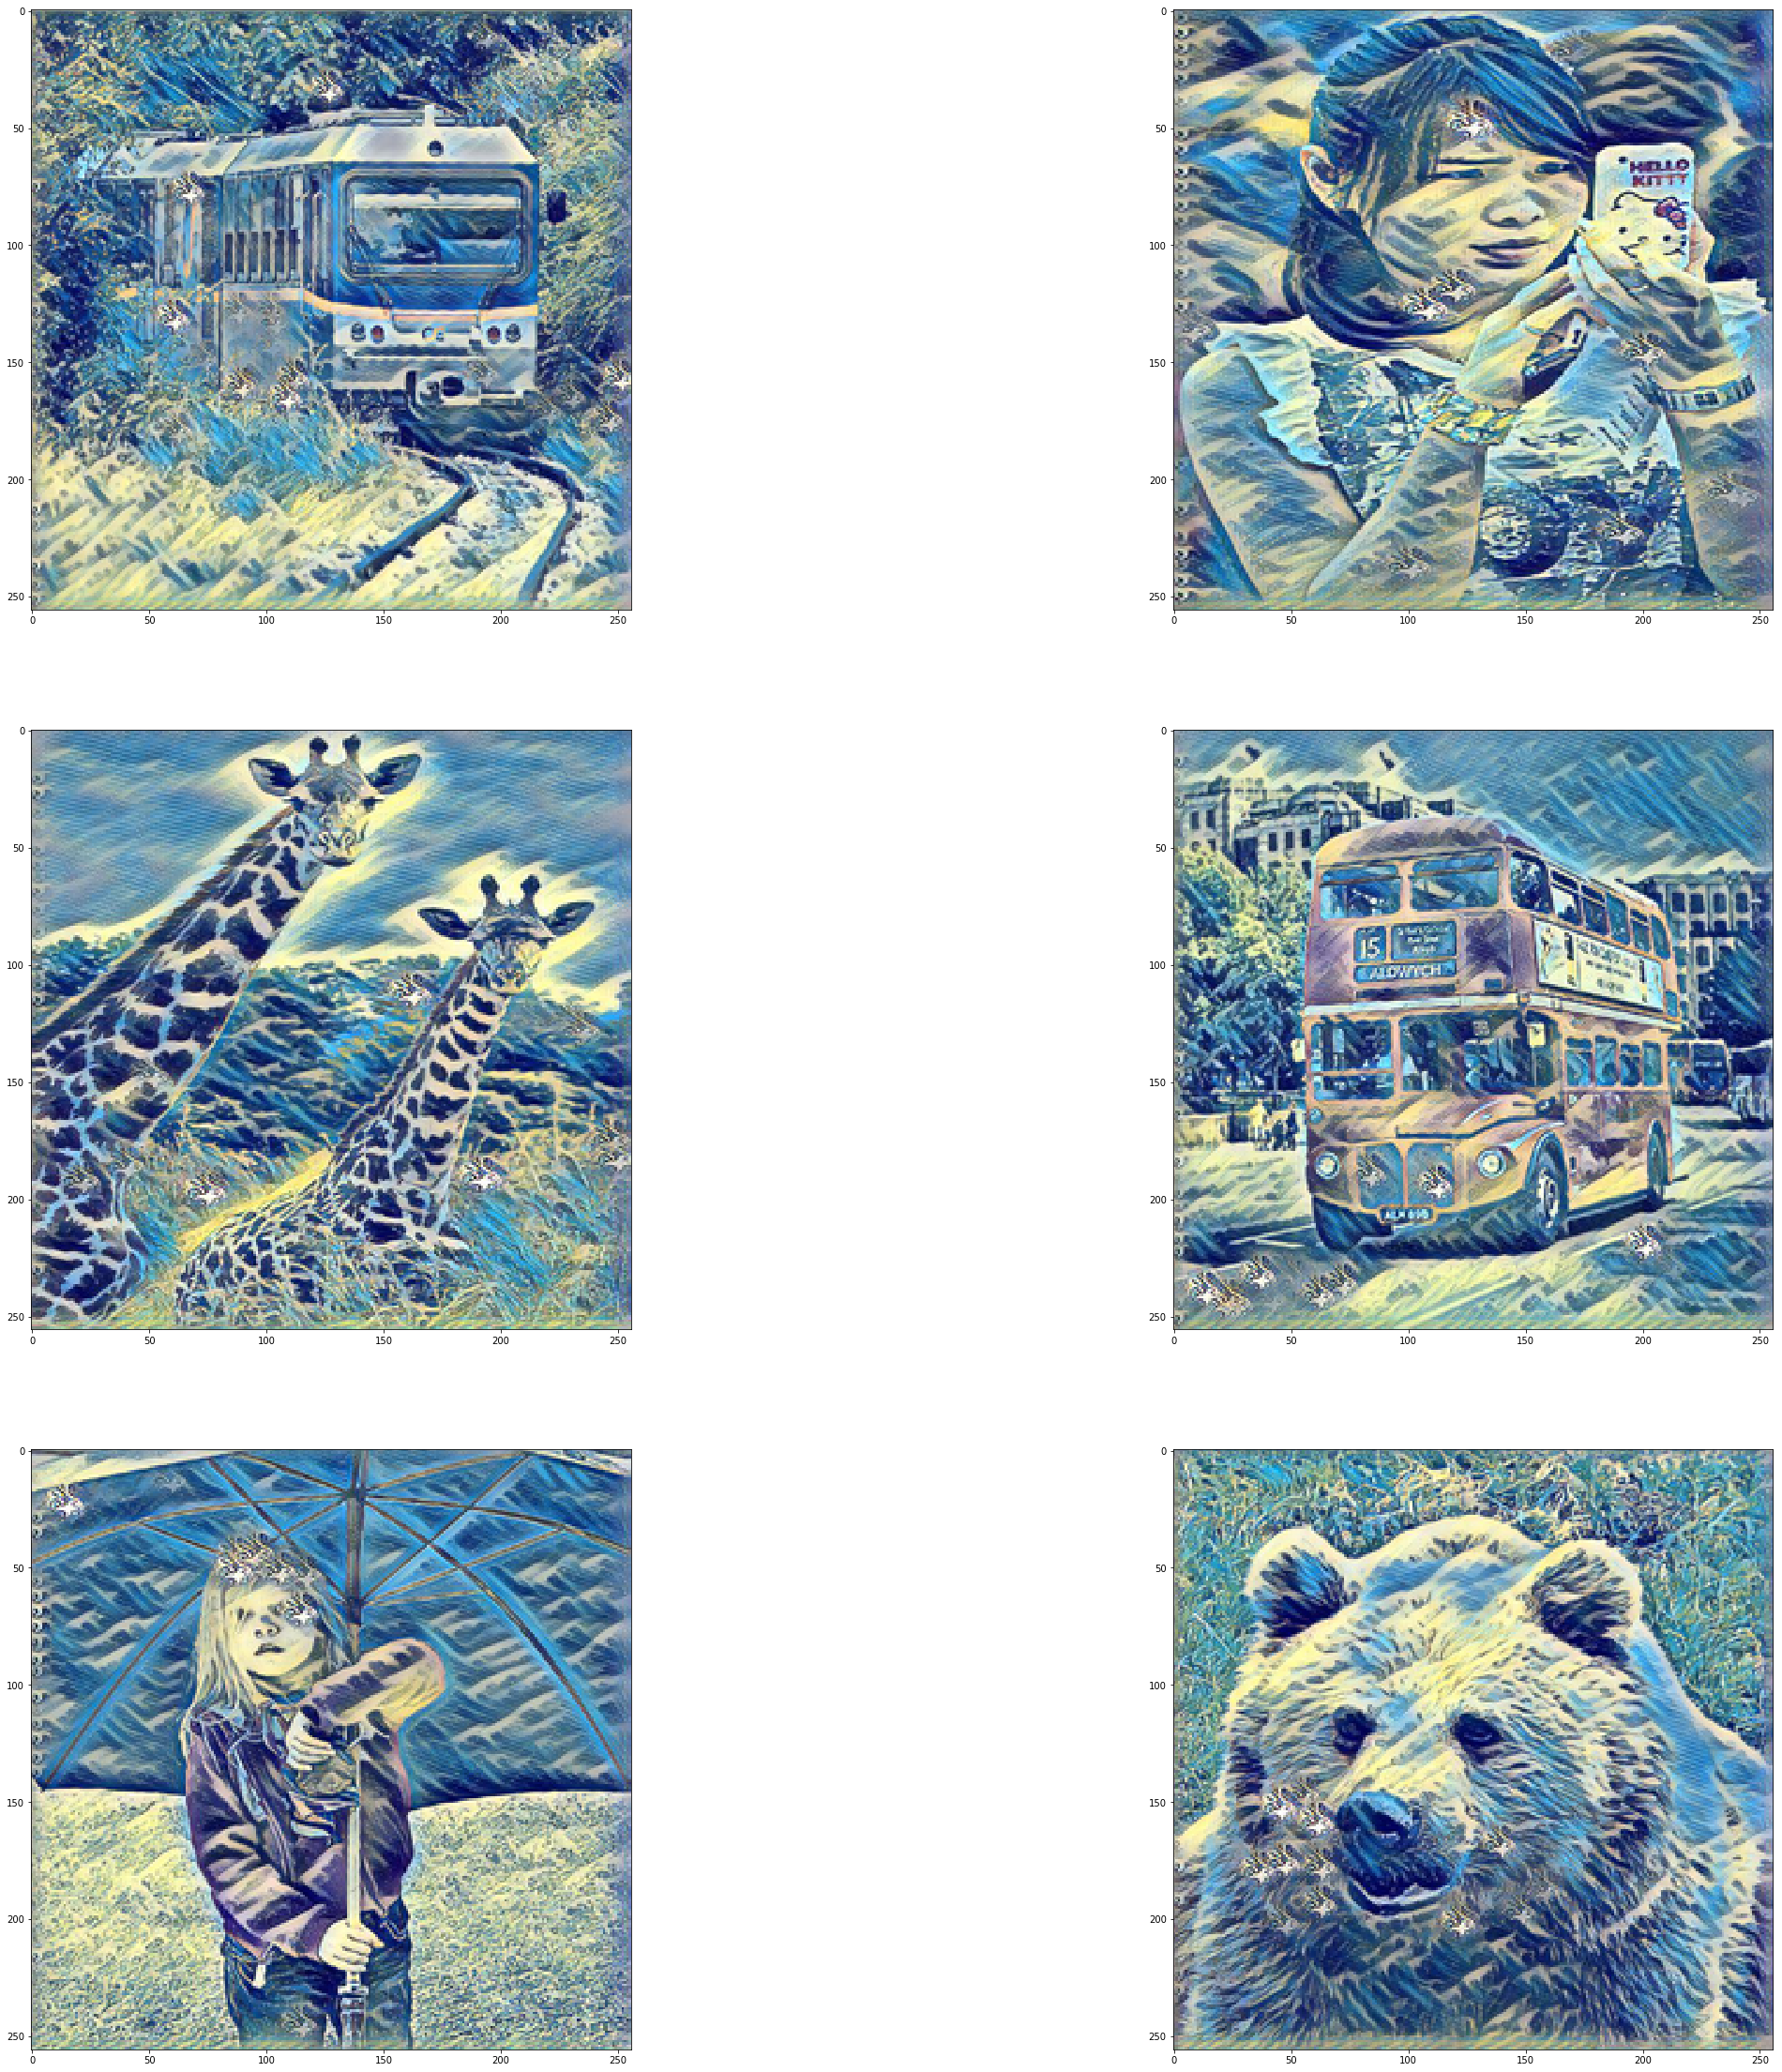

In [61]:
# visualize stylizations of all images from images/contents with style1
sea = []
boat = []
for file in os.listdir(path_r):
    if file.startswith('sea'):
        sea.append(load_image(path_r + file, size))
    if file.startswith('puantilism'):
        boat.append(load_image(path_r + file, size))
fig = plt.figure(figsize=(40, 40))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(sea[i])
plt.show()

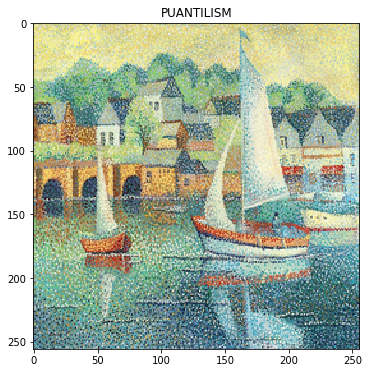

In [62]:
# visualize style2 from images/styles
fig = plt.figure(figsize=(6, 6))
plt.imshow(styles[1])
plt.title("PUANTILISM")
plt.show()

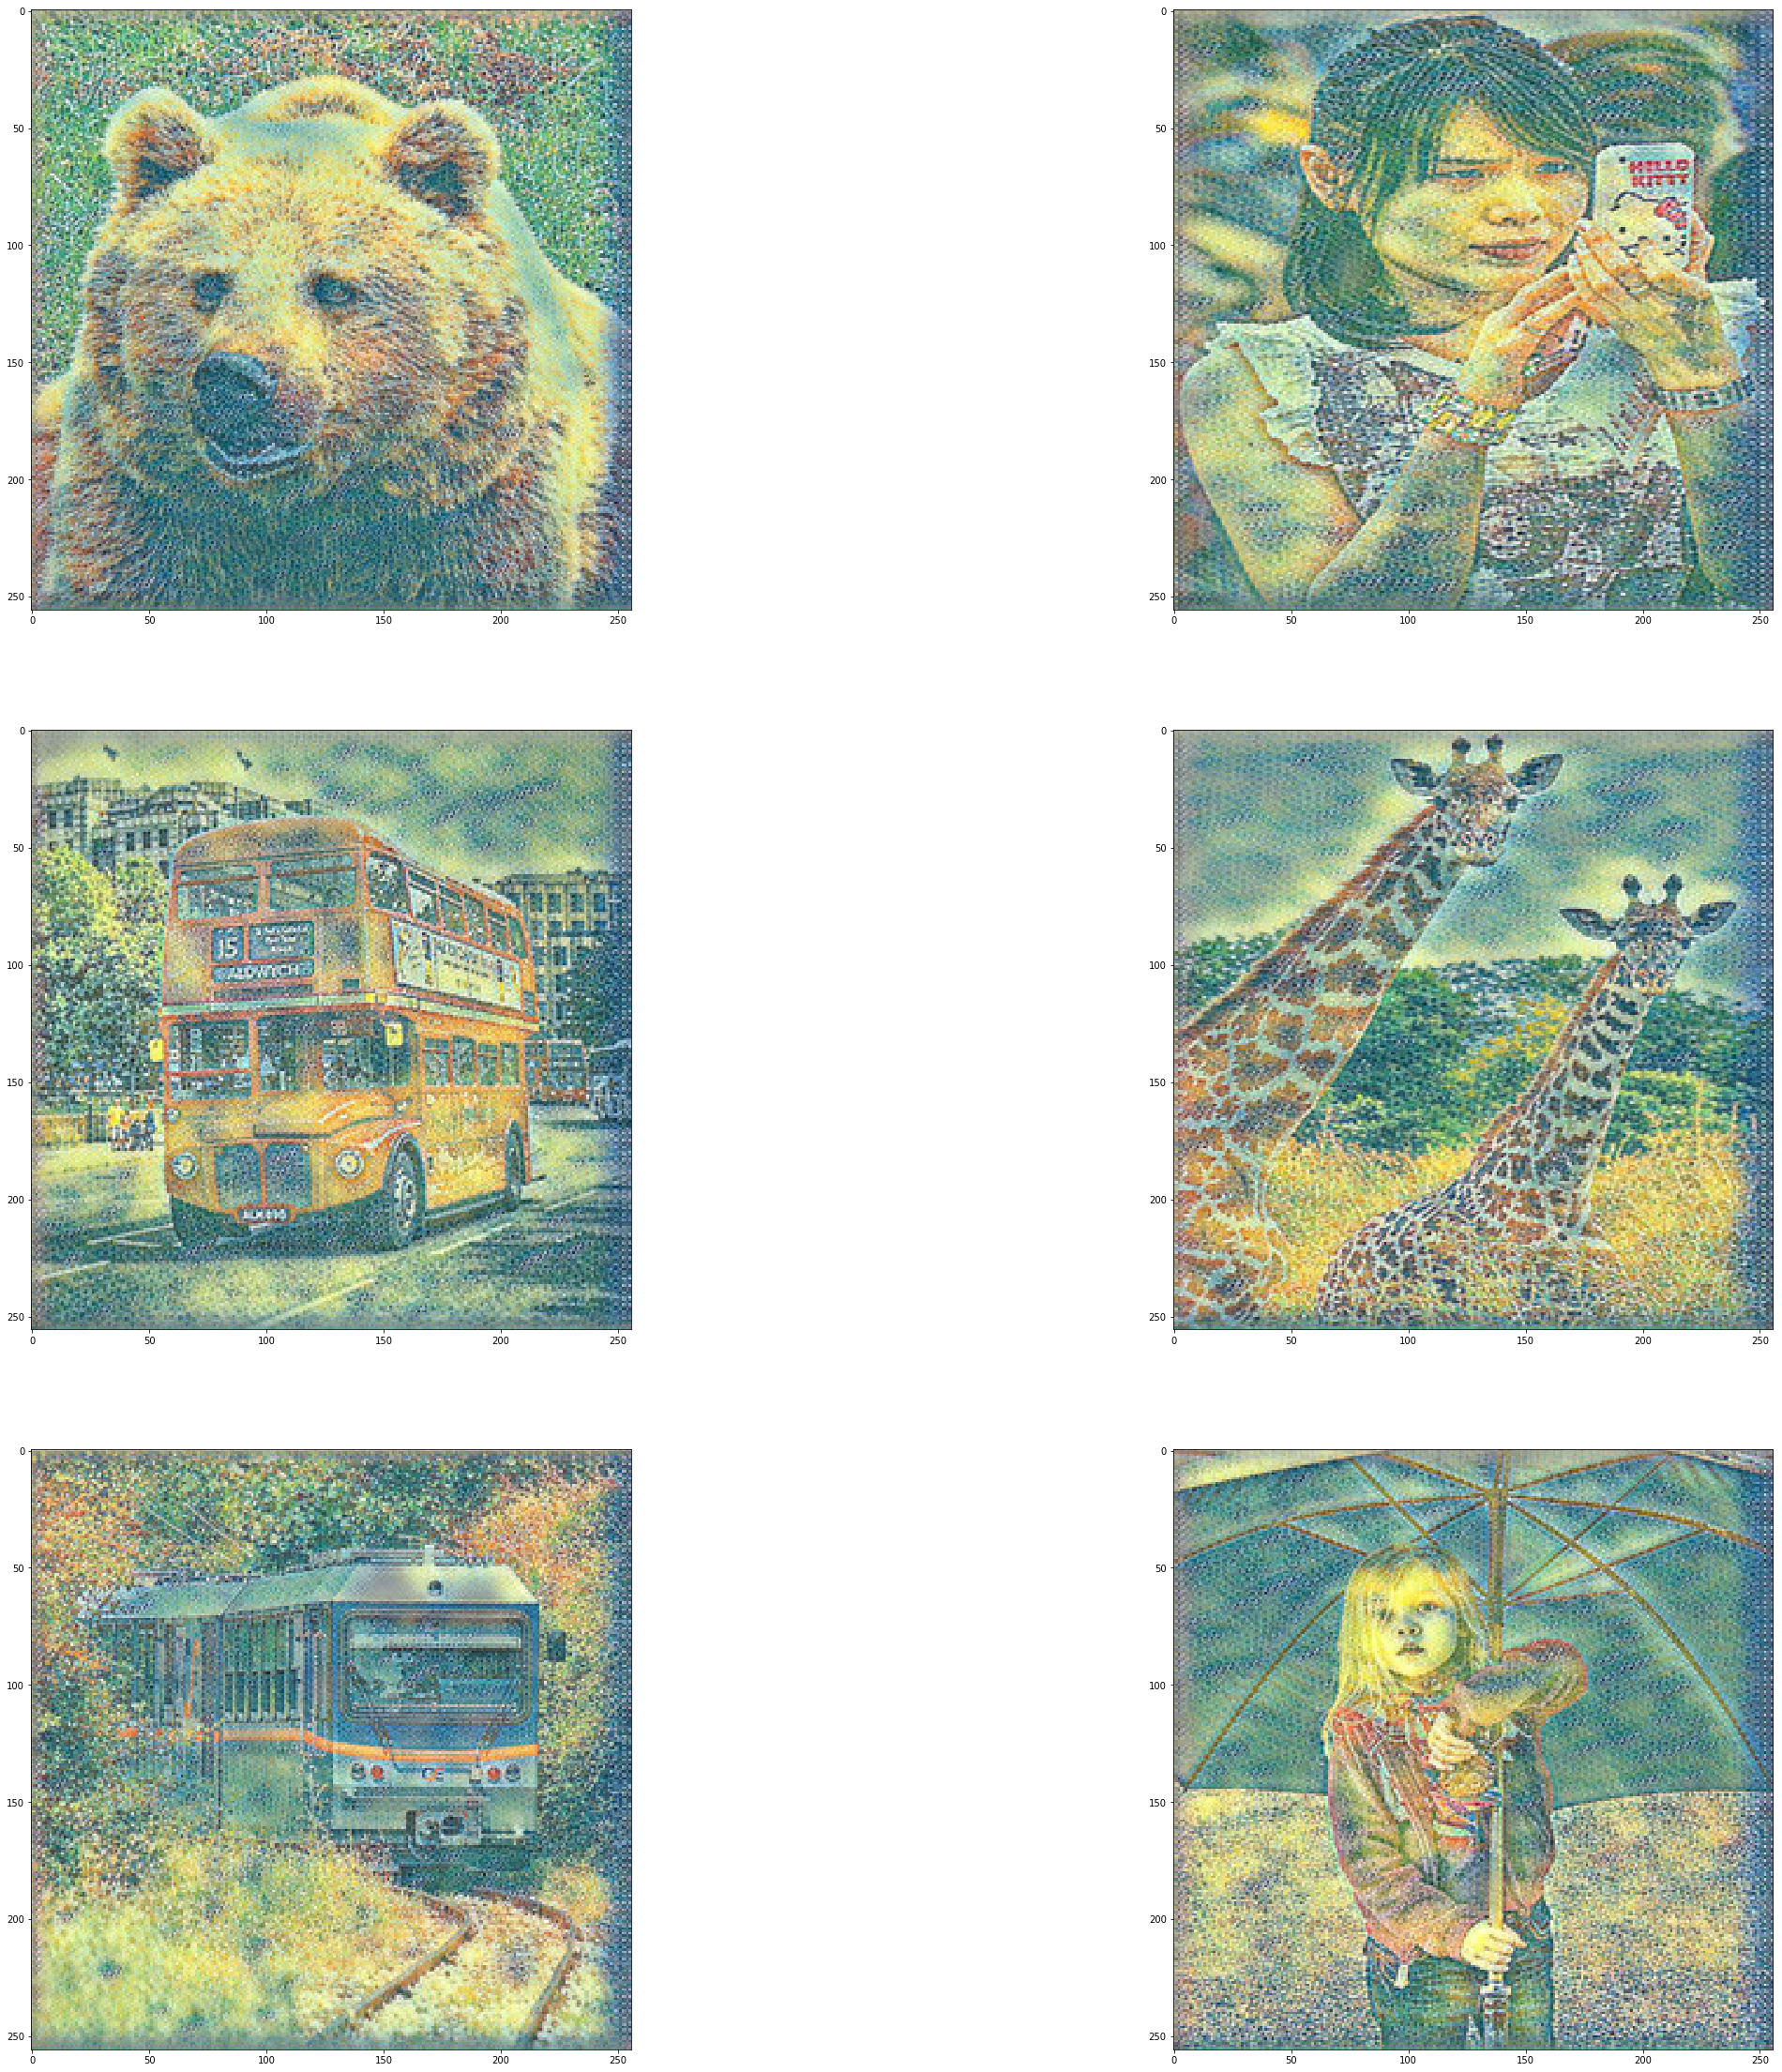

In [63]:
# visualize stylizations of all images from images/contents with style2
fig = plt.figure(figsize=(40, 40))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(boat[i])
plt.show()

# Ваши идеи по переносу стиля 

#### (общему - из лекций, необязательно online style transfer)

###### 1. Напишите в свободной форме ваши пожелания, какой бы дополнительный функционал 
###### возможностей, вам кажется, был бы полезен в технологии style transfer?

Мне кажется данная технология достигла довольно высоких результатов, и содержит широкий спектр возможностей переноса стиля. В качестве дополнения можно выделять некоторые детали на стилевом изображении, которые необходимо в точности повторить на полученном изображении, например: подпись автора внизу картины.

##### 2. Напишите ваши идеи (можно в общем) усовершенствования сущетвующих моделей style transfer.

Перенос стиля осуществляется со всего изображения, и иногда некоторые особенности стилевой картины утрачиваются, особенно если стилевое изображение и содержательное на совсем разную тематику, например на стилевом изображении нарисован пейзаж, а на картинке с содержанием гостиная. При выделении таких особенностей автора стиля можно усовершенствовать модель.